# Customer Churn Prediction: Model Building

## Project Overview

This notebook builds on the exploratory data analysis performed in `01_data_exploratory.ipynb` to develop a machine learning models that predict customer churn with high accuracy. I'll evaluate multiple model approaches, tune hyperparameters, and select the best model for production use.


## 1.0 Environment Setup

### 1.1 Library Imports


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import joblib
import warnings

Machine learning libraries


In [112]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.impute import SimpleImputer

Feature Selection


In [113]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV

Models


In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

Metrics


In [115]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    average_precision_score,
    make_scorer,
)

Visualization libraries


In [116]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

### 1.2 Environment Configuration


Suppress warnings for cleaner notebook output


In [117]:
warnings.filterwarnings("ignore")

Set matplotlib and seaborn style


In [118]:
plt.style.use("seaborn-v0_8-whitegrid")

In [119]:
custom_palette = [
    "#4e79a7",
    "#f28e2b",
    "#e15759",
    "#76b7b2",
    "#59a14f",
    "#edc948",
    "#b07aa1",
    "#ff9da7",
    "#9c755f",
    "#bab0ac",
]

sns.set_palette(custom_palette)

Figure settings


In [120]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

Pandas display settings


In [121]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

### 1.3 Project Configuration


In [122]:
CONFIG = {
    "random_seed": 42,
    "test_size": 0.2,
    "validation_size": 0.25,
    "cv_folds": 5,
    "data_path": "../data/processed/cleaned_churn_data.csv",
    "figures_path": "../reports/figures/",
    "models_path": "../models/",
    "results_path": "../reports/results/",
    "target_column": "Churn",
    "positive_class": "Yes",
    "id_column": "customerID",
    "n_jobs": -1,
}

In [123]:
for path in [CONFIG["figures_path"], CONFIG["models_path"], CONFIG["results_path"]]:
    Path(path).mkdir(parents=True, exist_ok=True)

Set random seed for reproducibility


In [124]:
np.random.seed(CONFIG["random_seed"])

### 1.4 Utility Functions


In [125]:
def save_fig(fig: plt.Figure, filename: str, dpi: int = 300):
    """
    Save a matplotlib figure with a standardized format

    Args:
      fig (plt.Figure): The matplotlib figure to save
      filename (str): The name of the file to save the figure as
      dpi (int, optional): The resolution of the saved figure in dots
    """

    full_path = Path(CONFIG["figures_path"]) / filename
    fig.savefig(full_path, bbox_inches="tight", dpi=dpi)

    print(f"Figure saved: {full_path}")

In [126]:
def format_runtime(seconds):
    """
    Format runtime in human-readable format
    """

    if seconds < 60:
        return f"{seconds:.2f} seconds"

    elif seconds < 3600:
        minutes = seconds / 60
        return f"{minutes:.2f} minutes"

    else:
        hours = seconds / 3600
        return f"{hours:.2f} hours"

In [127]:
def plot_model_evaluation(y_true, y_pred, y_pred_proba, model_name="Model"):
    """
    Plot comprehensive model evaluation visualizations in a single subplot

    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_pred_proba: Predicted probabilities for the positive class
        model_name: Name of the model for reporting

    Returns:
        fig: The figure object with all subplots
    """

    fig, axs = plt.subplots(2, 2, figsize=(18, 16))
    fig.suptitle(f"Model Evaluation: {model_name}", fontsize=20)

    # 1. Confusion Matrix (top left)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[0, 0], cbar=False)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axs[0, 0].text(
                j + 0.5,
                i + 0.7,
                f"{cm_norm[i, j]:.1%}",
                ha="center",
                va="center",
                color="black" if cm_norm[i, j] < 0.5 else "white",
            )

    axs[0, 0].set_xlabel("Predicted")
    axs[0, 0].set_ylabel("Actual")
    axs[0, 0].set_title("Confusion Matrix")
    axs[0, 0].set_xticklabels(["No Churn", "Churn"])
    axs[0, 0].set_yticklabels(["No Churn", "Churn"])

    # 2. ROC Curve (top right)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    axs[0, 1].plot(
        fpr, tpr, color="#4e79a7", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})"
    )

    axs[0, 1].plot(
        [0, 1],
        [0, 1],
        color="gray",
        lw=1,
        linestyle="--",
        label="Random Classifier (AUC = 0.5)",
    )

    axs[0, 1].set_xlabel("False Positive Rate")
    axs[0, 1].set_ylabel("True Positive Rate")
    axs[0, 1].set_title("ROC Curve")
    axs[0, 1].legend(loc="lower right")
    axs[0, 1].grid(alpha=0.3)

    # 3. Precision-Recall Curve (bottom left)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)

    axs[1, 0].plot(
        recall,
        precision,
        color="#e15759",
        lw=2,
        label=f"PR Curve (AP = {avg_precision:.3f})",
    )

    no_skill = len(y_true[y_true == 1]) / len(y_true)
    axs[1, 0].plot(
        [0, 1],
        [no_skill, no_skill],
        color="gray",
        lw=1,
        linestyle="--",
        label=f"No Skill Classifier (AP = {no_skill:.3f})",
    )

    axs[1, 0].set_xlabel("Recall")
    axs[1, 0].set_ylabel("Precision")
    axs[1, 0].set_title("Precision-Recall Curve")
    axs[1, 0].legend(loc="upper right")
    axs[1, 0].grid(alpha=0.3)

    # 4. Performance Metrics Table (bottom right)
    accuracy = accuracy_score(y_true, y_pred)
    precision_score_val = precision_score(y_true, y_pred)
    recall_score_val = recall_score(y_true, y_pred)
    f1_score_val = f1_score(y_true, y_pred)
    roc_auc_score_val = roc_auc_score(y_true, y_pred_proba)

    # Compute confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    axs[1, 1].axis("off")
    metrics_data = [
        ["Metric", "Value"],
        ["Accuracy", f"{accuracy:.4f}"],
        ["Precision", f"{precision_score_val:.4f}"],
        ["Recall", f"{recall_score_val:.4f}"],
        ["F1 Score", f"{f1_score_val:.4f}"],
        ["ROC AUC", f"{roc_auc_score_val:.4f}"],
        ["Avg Precision", f"{avg_precision:.4f}"],
        ["Specificity", f"{specificity:.4f}"],
    ]

    table = axs[1, 1].table(
        cellText=metrics_data, loc="center", cellLoc="center", colWidths=[0.4, 0.3]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)

    for i in range(len(metrics_data[0])):
        table[(0, i)].set_facecolor("#4e79a7")
        table[(0, i)].set_text_props(color="white", fontweight="bold")

    axs[1, 1].set_title("Performance Metrics", pad=30)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    return fig

In [128]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive model evaluation suite

    Args:
        model: Trained model with predict and predict_proba methods
        X_test: Test features
        y_test: Test target
        model_name: Name of the model for reporting

    Returns:
        dict: Dictionary of performance metrics
    """
    
    start_time = time.time()

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    print(f"\n{'='*50}")
    print(f"Model Evaluation: {model_name}")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nConfusion Matrix:")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    fig = plot_model_evaluation(y_test, y_pred, y_pred_proba, model_name)
    save_fig(fig, f"model_evaluation_{model_name.lower().replace(' ', '_')}.png")
    plt.show()

    exec_time = time.time() - start_time
    print(f"\nEvaluation completed in {format_runtime(exec_time)}")

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "avg_precision": avg_precision,
        "specificity": specificity,
        "confusion_matrix": cm,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "exec_time": exec_time,
    }

In [129]:
def save_model(model, model_name: str):
    """
    Saved a trained model to disk

    Args:
      model: The trained model object
      model_name (str): Name to use when saving the model
    """

    full_path = Path(CONFIG["models_path"]) / f"{model_name}.pkl"
    joblib.dump(model, full_path)

    print(f"Model saved: {full_path}")

In [130]:
def plot_feature_importance(model, feature_names, title="Feature Importance", top_n=20):
    """
    Plot feature importances for a model

    Args:
        model: Trained model with feature_importances_ attribute
        feature_names: List of feature names
        title: Title for the plot
        top_n: Number of top features to show
    """

    try:
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_

        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_[0])

        elif hasattr(model, "named_steps") and hasattr(
            model.named_steps["classifier"], "feature_importances_"
        ):
            importances = model.named_steps["classifier"].feature_importances_

        elif hasattr(model, "named_steps") and hasattr(
            model.named_steps["classifier"], "coef_"
        ):
            importances = np.abs(model.named_steps["classifier"].coef_[0])

        else:
            print("Model doesn't support direct feature importance extraction")
            return None

        importance_df = pd.DataFrame(
            {"Feature": feature_names, "Importance": importances}
        )

        importance_df = importance_df.sort_values("Importance", ascending=False).head(
            top_n
        )

        fig, ax = plt.subplots(figsize=(12, 10))
        sns.barplot(x="Importance", y="Feature", data=importance_df, ax=ax)

        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Importance Score", fontsize=14)
        ax.set_ylabel("", fontsize=14)

        plt.tight_layout()
        return fig

    except Exception as e:
        print(f"Error plotting feature importance: {str(e)}")
        return None

## 2.0 Load & Prepare Data


In [131]:
project_start_time = time.time()
data_load_start = time.time()

Load cleaned data


In [132]:
df = pd.read_csv(CONFIG["data_path"])

In [133]:
data_load_time = time.time() - data_load_start
print(f"Dataset loaded in {format_runtime(data_load_time)}")
print(f"Dataset dimensions: {df.shape[0]:,} rows, {df.shape[1]:,} columns")

Dataset loaded in 0.05 seconds
Dataset dimensions: 7,043 rows, 21 columns


In [134]:
display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Identify categorical, numerical, and target variables


In [135]:
id_cols = [CONFIG["id_column"]]
target_col = CONFIG["target_column"]

Get categorical and numerical features, excluding engineered features added in the EDA


In [136]:
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

Remove ID and target columns from feature lists


In [137]:
categorical_cols = [
    col for col in categorical_cols if col not in id_cols + [target_col]
]

numerical_cols = [col for col in numerical_cols if col not in id_cols + [target_col]]

Check for engineered features from previous notebook


In [138]:
engineered_features = [
    "CLV",
    "ServiceCount",
    "AvgSpendPerService",
    "TenureGroup",
    "HasSecurityServices",
    "ContractDuration",
    "TenureContractRatio",
]

In [139]:
for feature in engineered_features:
    if feature in df.columns:
        if df[feature].dtype in ["int64", "float64"]:
            if feature not in numerical_cols:
                numerical_cols.append(feature)

        elif feature not in categorical_cols:
            categorical_cols.append(feature)

In [140]:
print(f"Target Column: {target_col}")
print(f"Categorical Features ({len(categorical_cols)}): {', '.join(categorical_cols)}")
print(f"Numerical Features ({len(numerical_cols)}): {', '.join(numerical_cols)}")

Target Column: Churn
Categorical Features (16): gender, SeniorCitizen, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod
Numerical Features (3): tenure, MonthlyCharges, TotalCharges


## 3.0 Data Preprocessing


Convert target to binary (1 = Churn, 0 = No Churn)


In [141]:
target_mapper = {CONFIG["positive_class"]: 1, "No": 0}
y = df[target_col].map(target_mapper).values

Create feature matrix (drop id and target columns)


In [142]:
X = df.drop(columns=[CONFIG["id_column"], target_col])
feature_names = X.columns.tolist()

Split data into train and test sets


In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=CONFIG["test_size"], random_state=CONFIG["random_seed"], stratify=y
)

In [144]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Churn rate in training set: {y_train.mean()*100:.2f}%")
print(f"Churn rate in test set: {y_test.mean()*100:.2f}%")

Training set: 5634 samples
Test set: 1409 samples
Churn rate in training set: 26.54%
Churn rate in test set: 26.54%


## 4.0 Create Model Pipelines


Define preprocessing for numerical and categorical features


In [145]:
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [146]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

Combine preprocessing steps


In [147]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

Create pipeline with preprocessing


In [148]:
def make_pipeline(classifier, name):
    """
    Create a machine learning pipeline with preprocessing and a classifier.

    Args:
      classifier: The machine learning classifier to use in the pipeline.
            This should be an instance of a scikit-learn classifier (e.g., LogisticRegression, RandomForestClassifier).
      name (str): A descriptive name for the pipeline, typically the name of the classifier.

    Returns:
      tuple: A tuple containing:
        - Pipeline: A scikit-learn Pipeline object with preprocessing and the specified classifier.
        - str: The name of the pipeline.
    """

    return (
        Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)]),
        name,
    )

Define model candidates


In [149]:
model_candidates = [
    make_pipeline(
        LogisticRegression(
            random_state=CONFIG["random_seed"], max_iter=1000, class_weight="balanced"
        ),
        "Logistic Regression",
    ),
    make_pipeline(
        RandomForestClassifier(
            random_state=CONFIG["random_seed"], class_weight="balanced"
        ),
        "Random Forest",
    ),
    make_pipeline(
        GradientBoostingClassifier(random_state=CONFIG["random_seed"]),
        "Gradient Boosting",
    ),
    make_pipeline(
        XGBClassifier(
            random_state=CONFIG["random_seed"],
            use_label_encoder=False,
            eval_metric="logloss",
        ),
        "XGBoost",
    ),
    make_pipeline(
        LGBMClassifier(random_state=CONFIG["random_seed"], verbose=-1), "LightGBM"
    ),
]

## 5.0 Baseline Model Training & Evaluation


Logistic Regression trained in 0.09 seconds

Model Evaluation: Logistic Regression
Accuracy: 0.7381
Precision: 0.5043
Recall: 0.7834
F1 Score: 0.6136
ROC AUC: 0.8415
Average Precision: 0.6325
Specificity: 0.7217

Confusion Matrix:
TN: 747, FP: 288, FN: 81, TP: 293

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



Figure saved: ../reports/figures/model_evaluation_logistic_regression.png


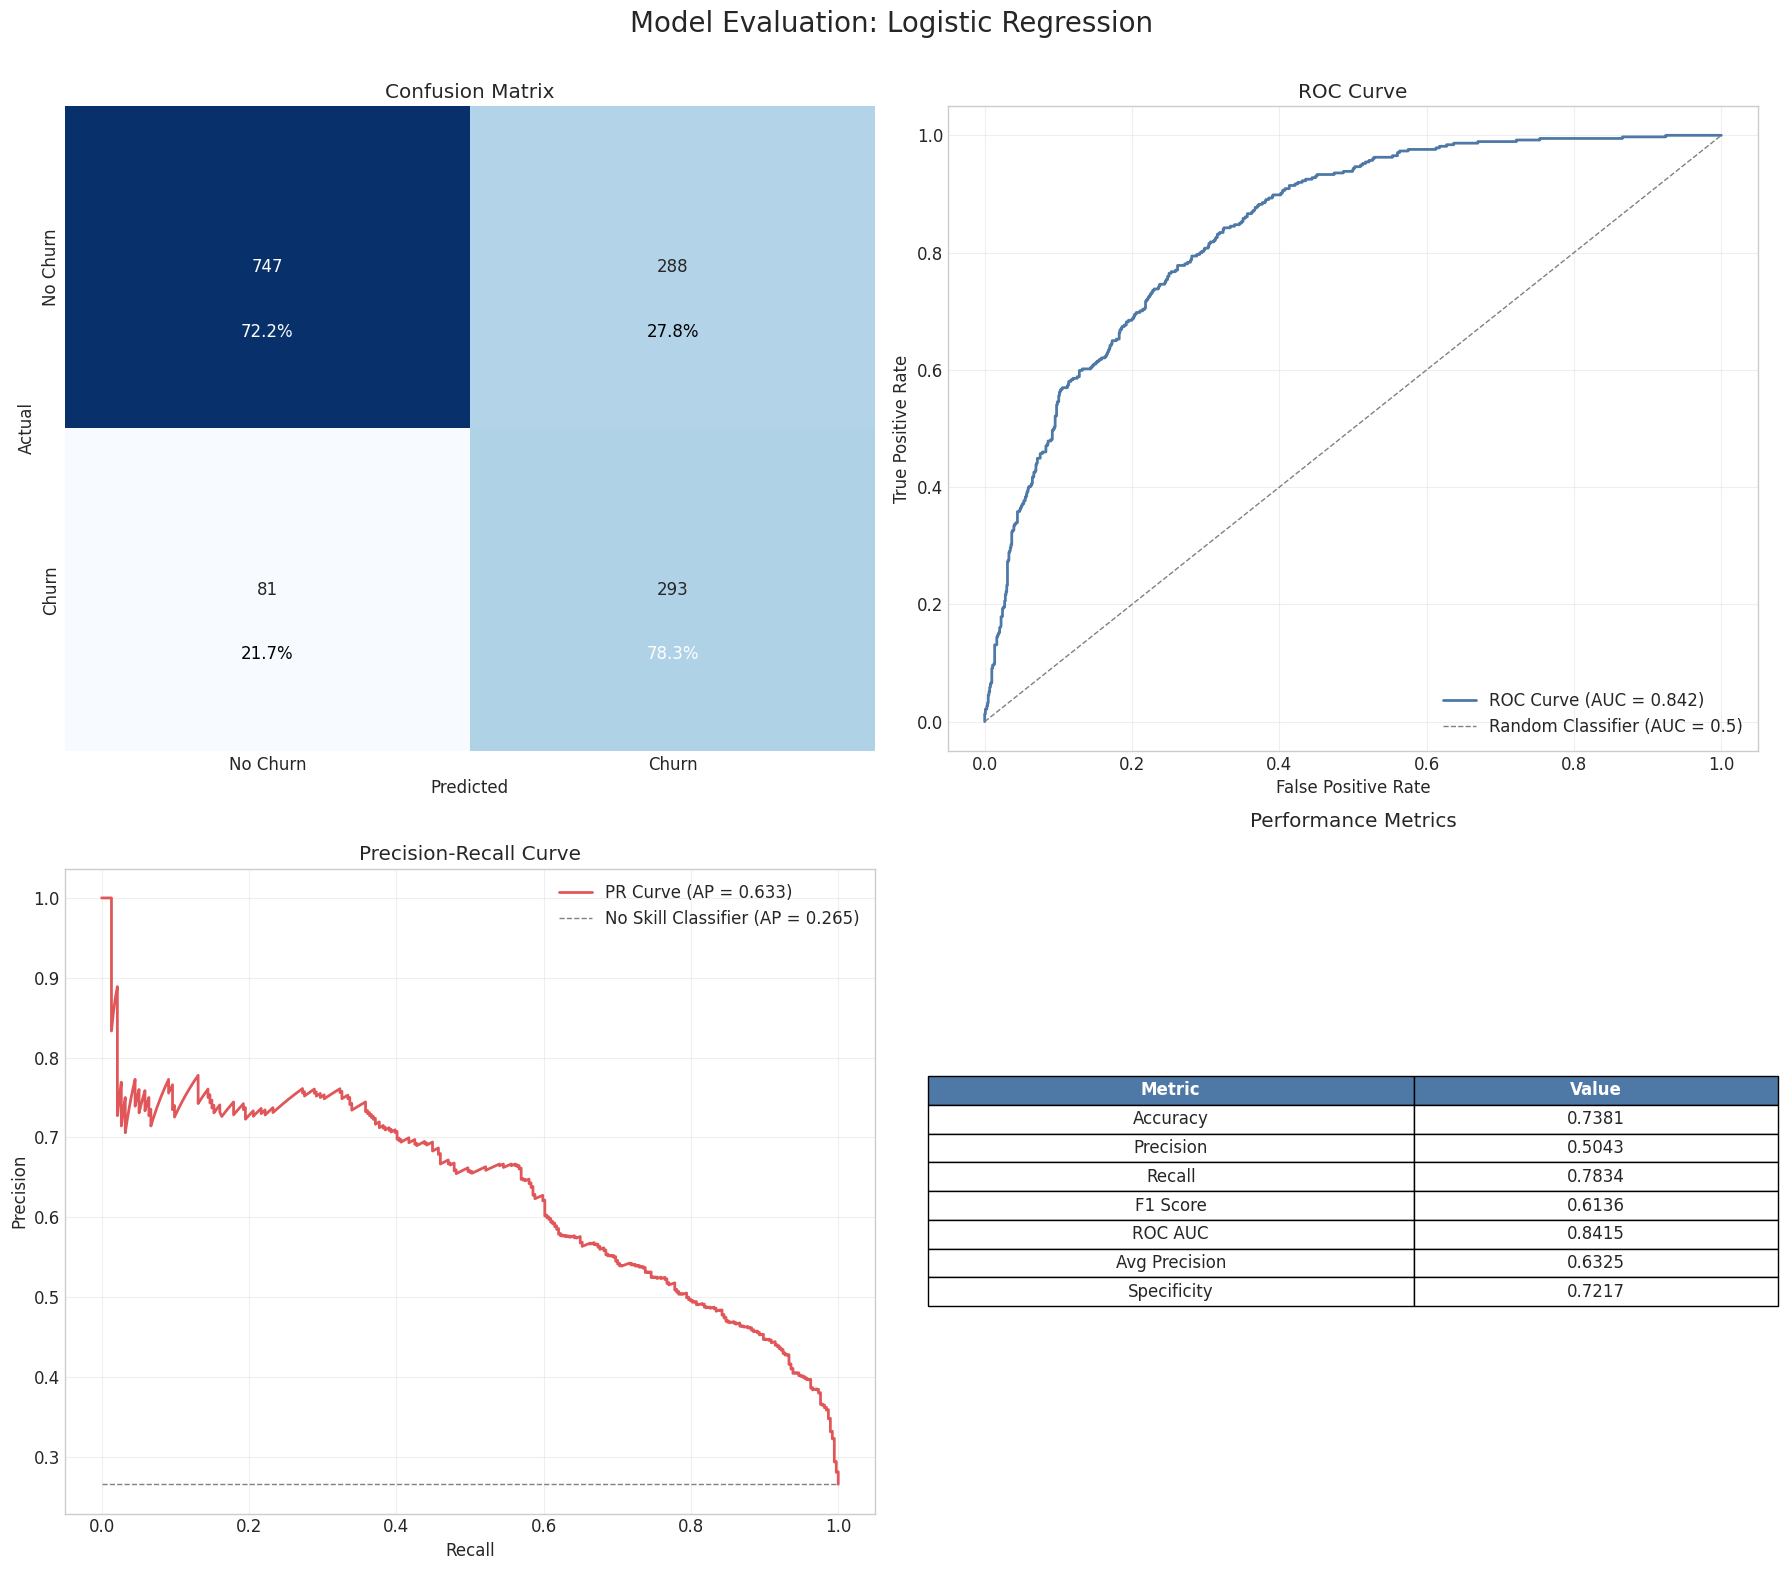


Evaluation completed in 2.17 seconds
Model saved: ../models/baseline_logistic_regression.pkl
Random Forest trained in -6.28 seconds

Model Evaluation: Random Forest
Accuracy: 0.7906
Precision: 0.6396
Recall: 0.4840
F1 Score: 0.5510
ROC AUC: 0.8222
Average Precision: 0.6144
Specificity: 0.9014

Confusion Matrix:
TN: 933, FP: 102, FN: 193, TP: 181

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Figure saved: ../reports/figures/model_evaluation_random_forest.png


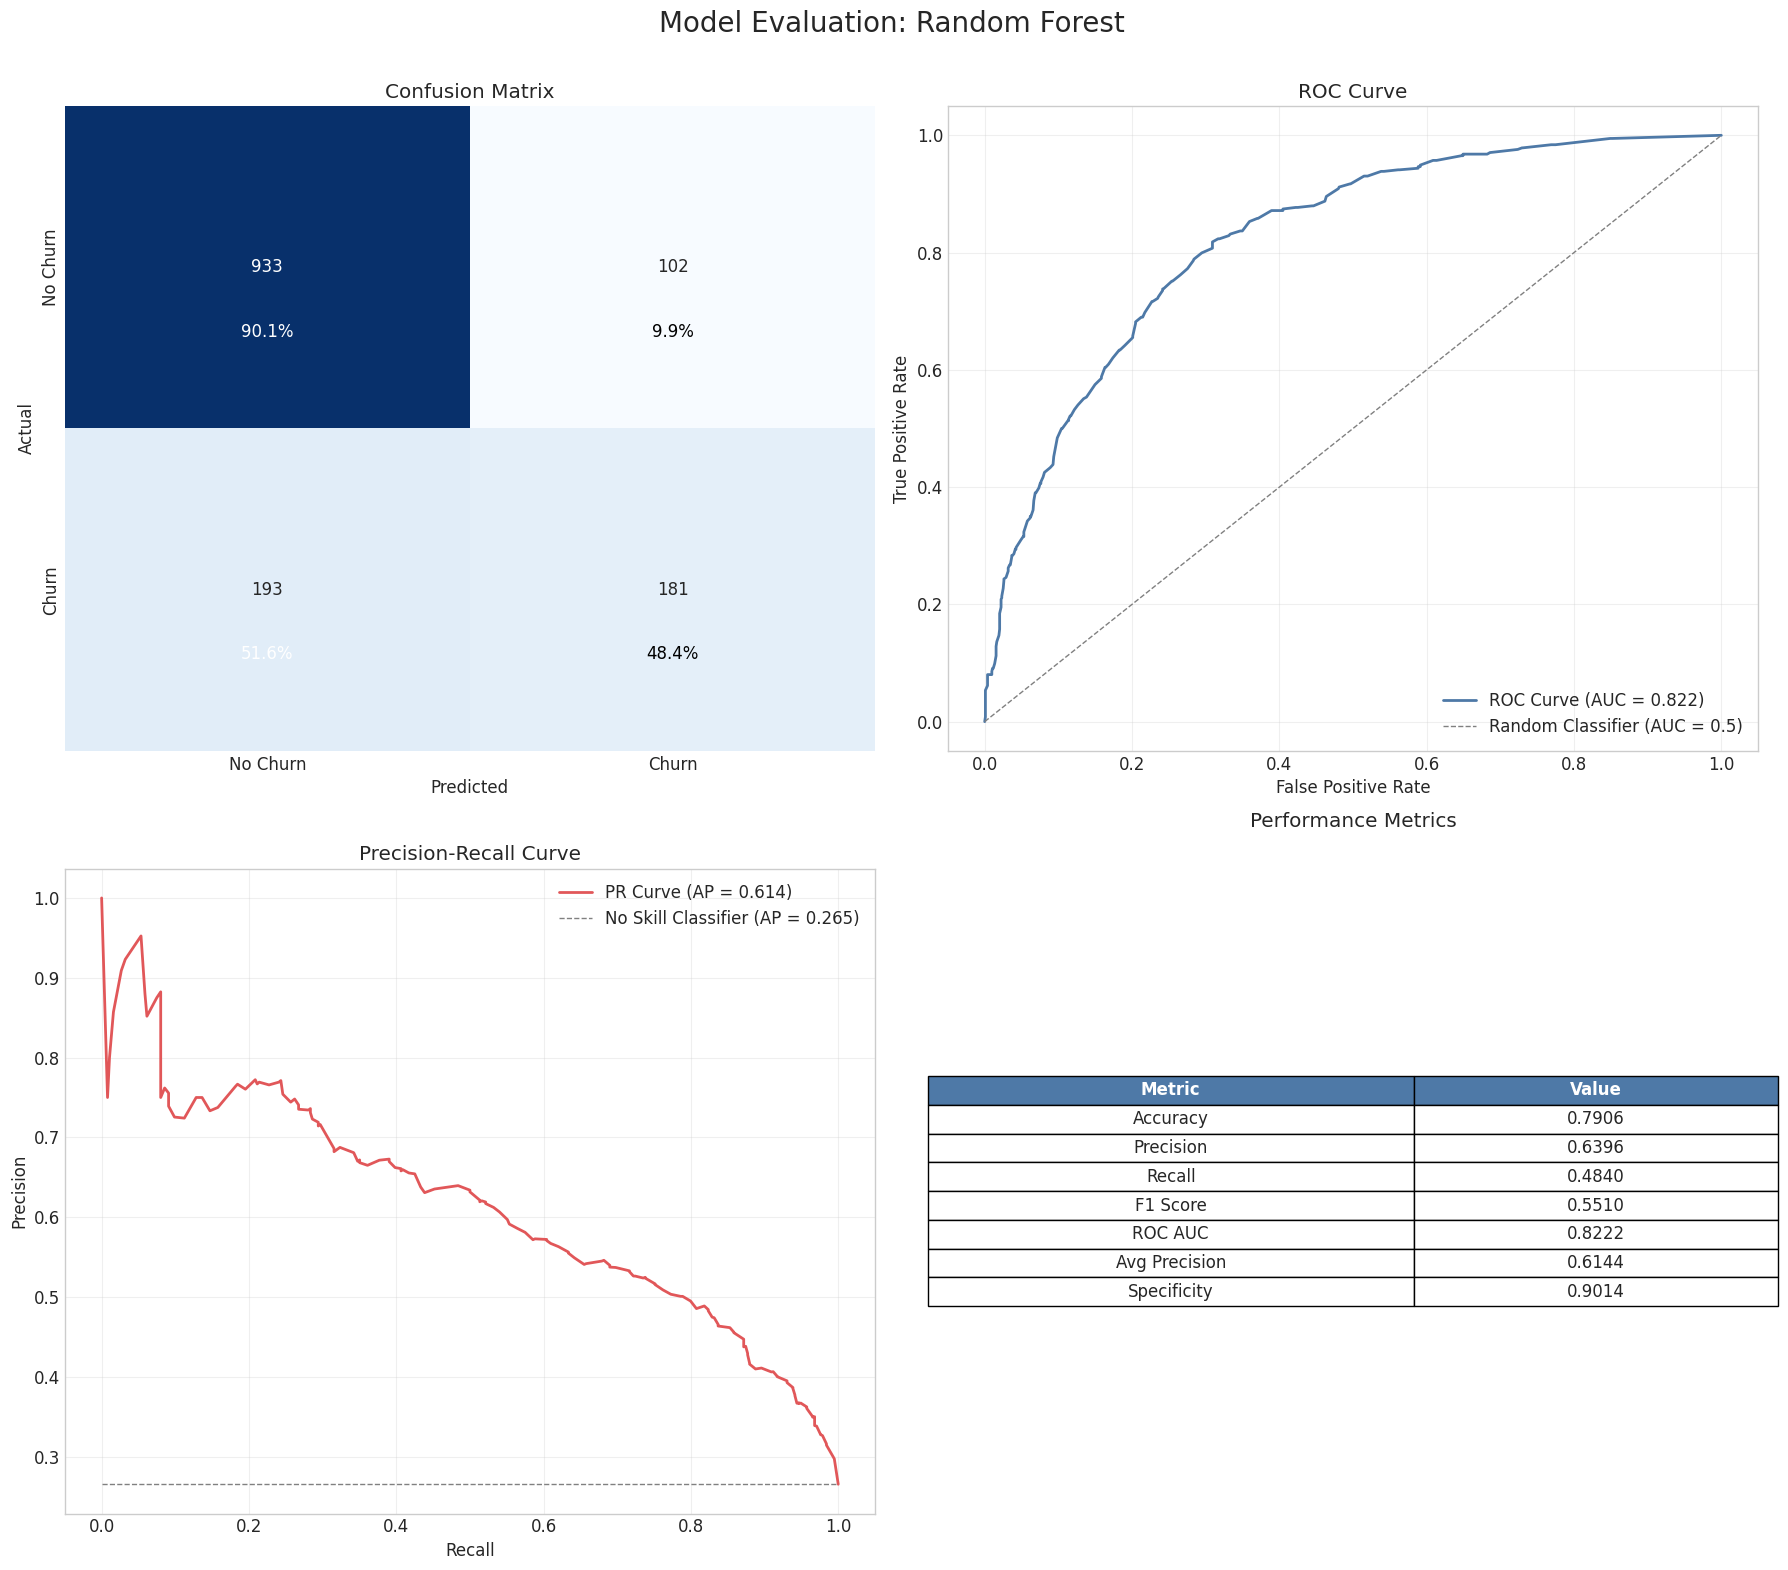


Evaluation completed in 11.37 seconds
Model saved: ../models/baseline_random_forest.pkl
Gradient Boosting trained in 1.00 seconds

Model Evaluation: Gradient Boosting
Accuracy: 0.8027
Precision: 0.6655
Recall: 0.5160
F1 Score: 0.5813
ROC AUC: 0.8434
Average Precision: 0.6604
Specificity: 0.9063

Confusion Matrix:
TN: 938, FP: 97, FN: 181, TP: 193

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Figure saved: ../reports/figures/model_evaluation_gradient_boosting.png


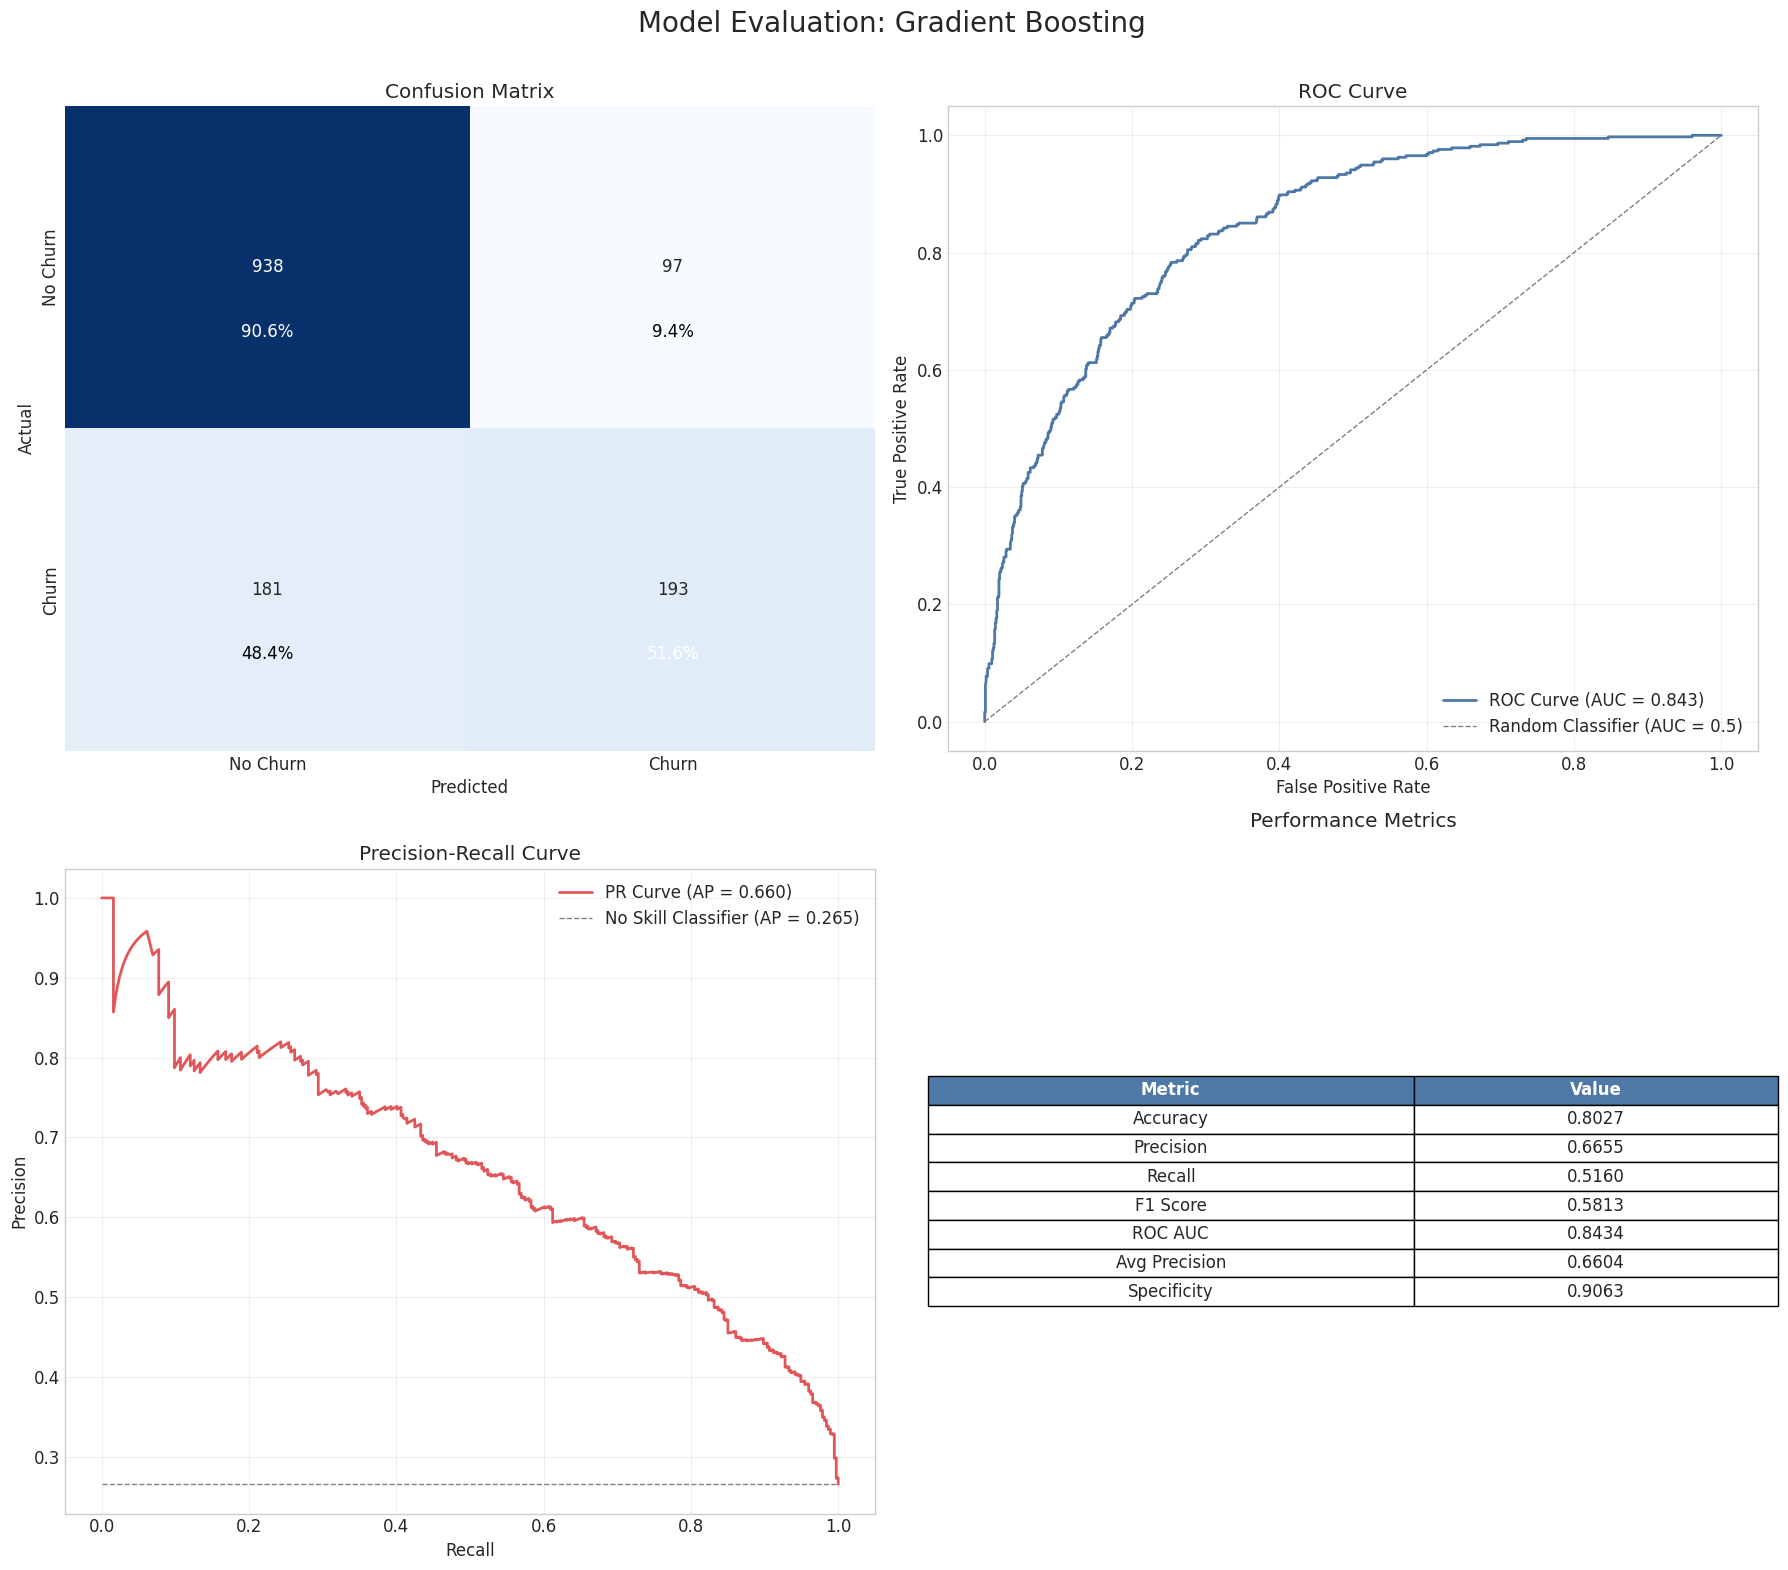


Evaluation completed in 1.77 seconds
Model saved: ../models/baseline_gradient_boosting.pkl
XGBoost trained in 0.32 seconds

Model Evaluation: XGBoost
Accuracy: 0.7729
Precision: 0.5823
Recall: 0.5107
F1 Score: 0.5442
ROC AUC: 0.8152
Average Precision: 0.6033
Specificity: 0.8676

Confusion Matrix:
TN: 898, FP: 137, FN: 183, TP: 191

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.51      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409

Figure saved: ../reports/figures/model_evaluation_xgboost.png


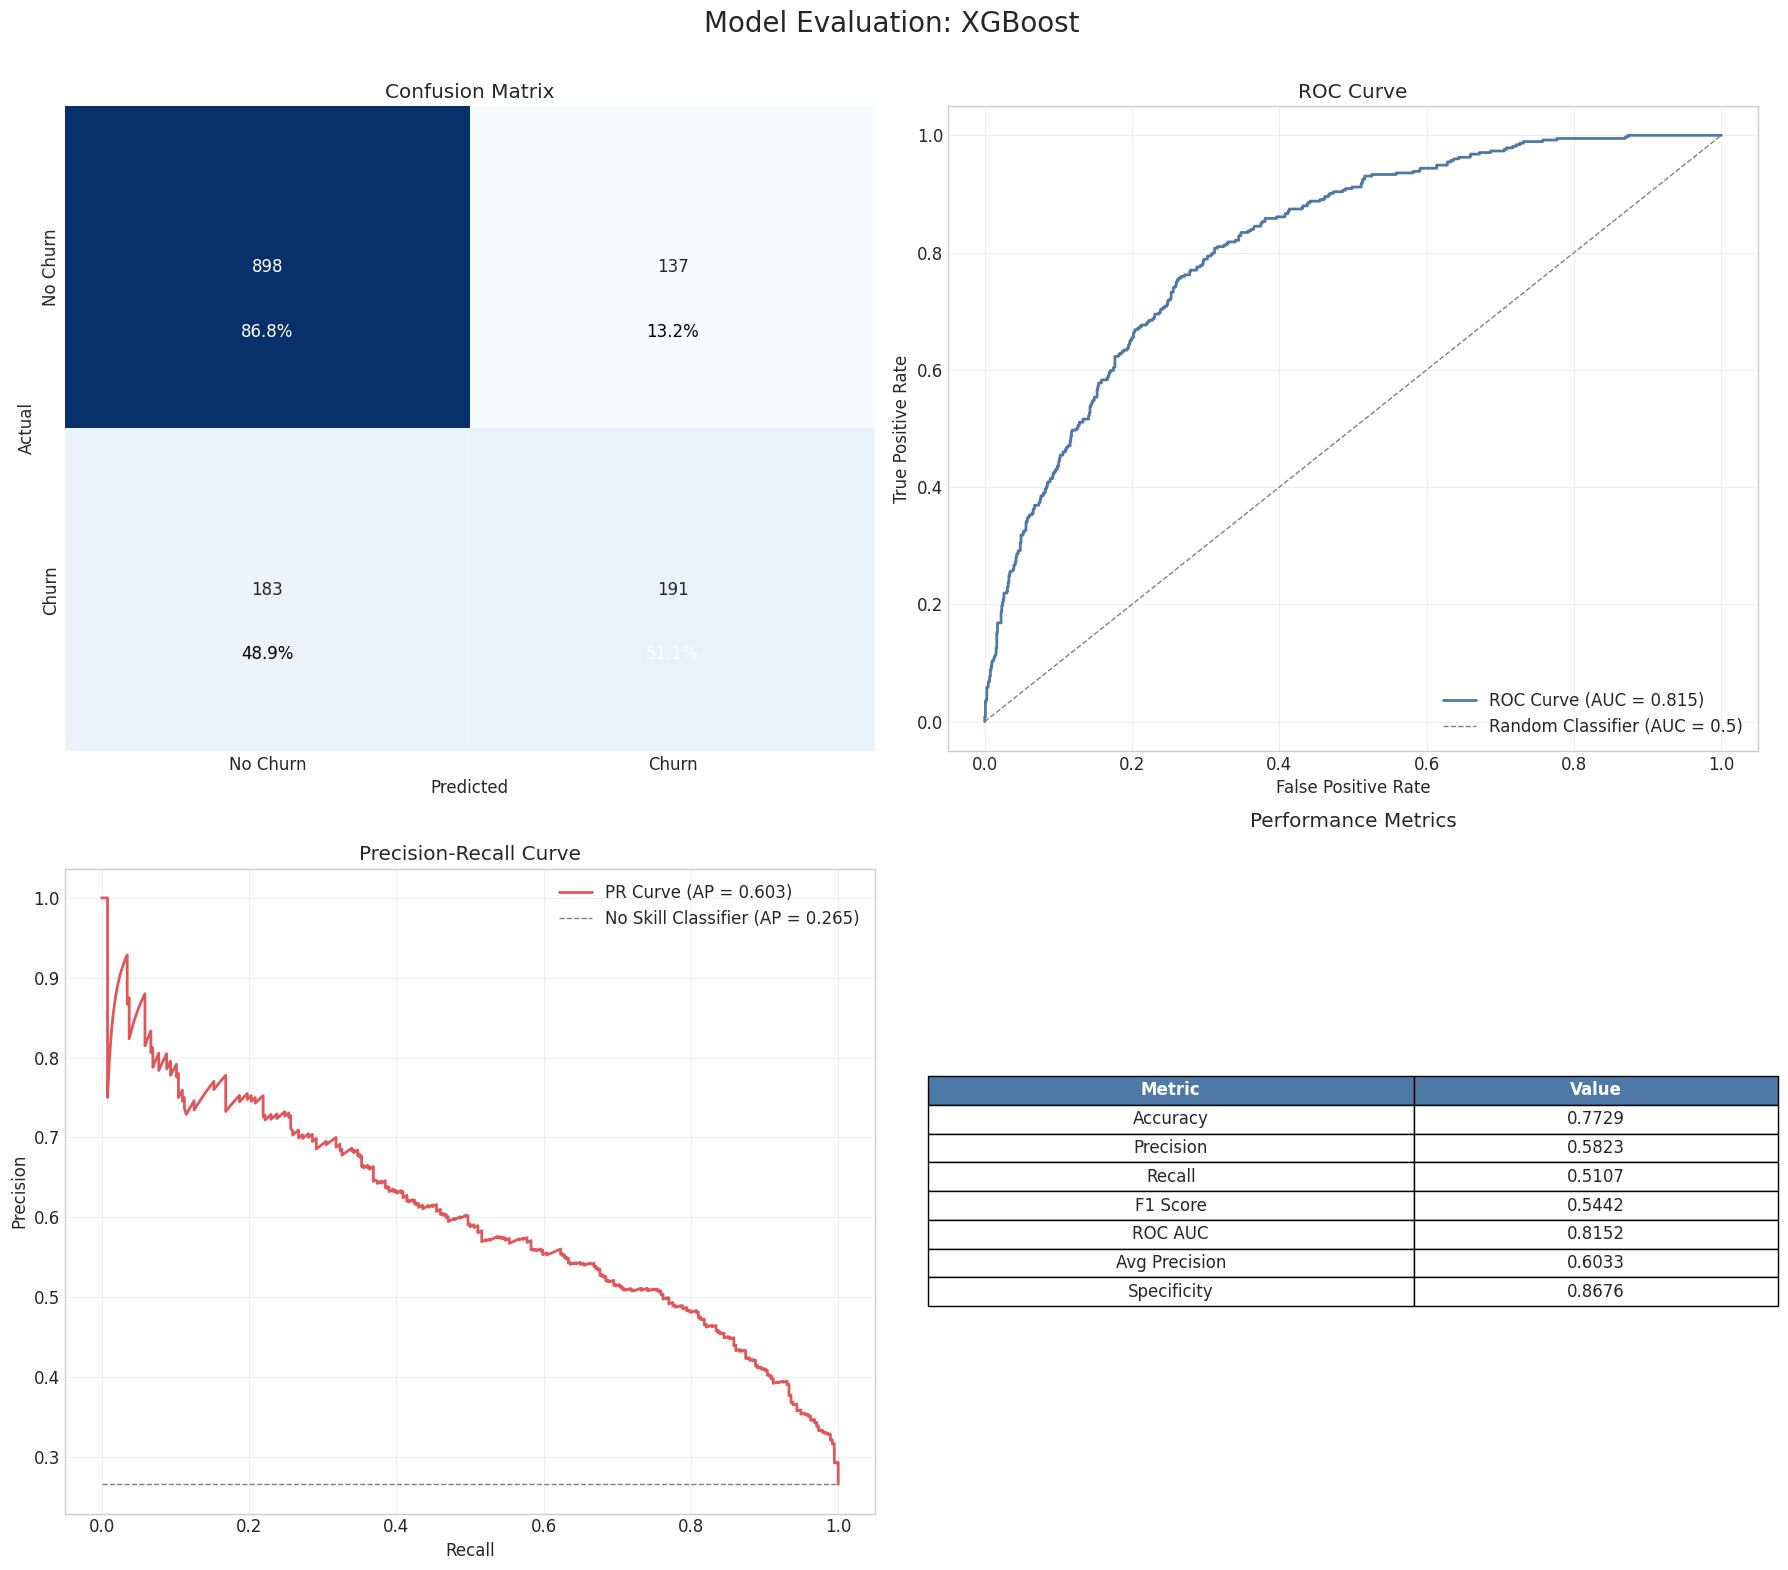


Evaluation completed in 1.68 seconds
Model saved: ../models/baseline_xgboost.pkl
LightGBM trained in 0.11 seconds

Model Evaluation: LightGBM
Accuracy: 0.7899
Precision: 0.6226
Recall: 0.5294
F1 Score: 0.5723
ROC AUC: 0.8330
Average Precision: 0.6416
Specificity: 0.8841

Confusion Matrix:
TN: 915, FP: 120, FN: 176, TP: 198

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409

Figure saved: ../reports/figures/model_evaluation_lightgbm.png


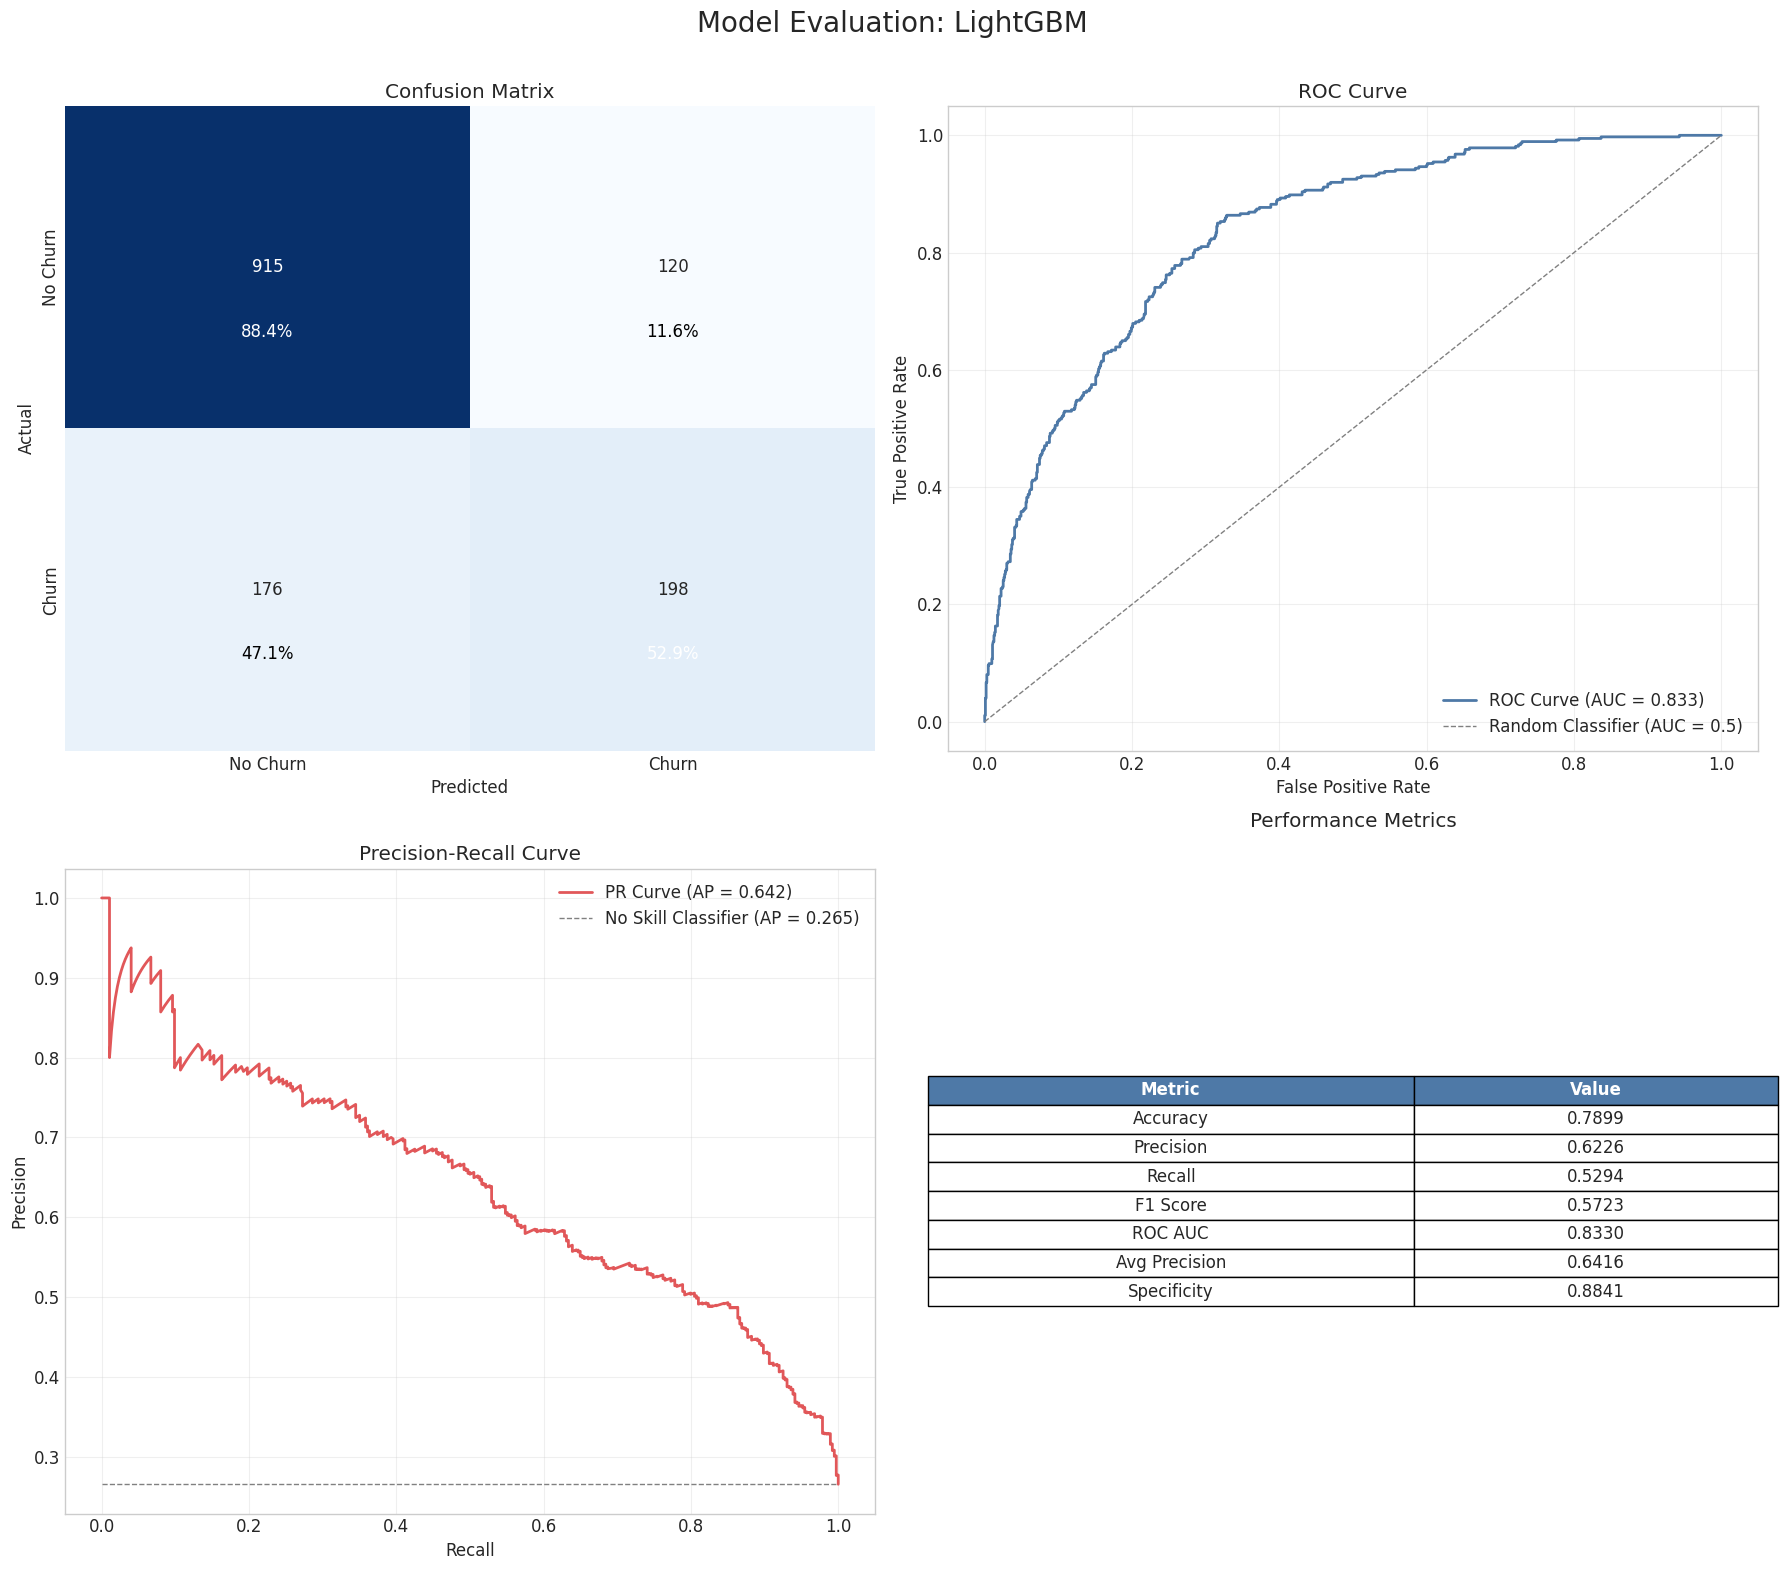


Evaluation completed in 1.77 seconds
Model saved: ../models/baseline_lightgbm.pkl


In [150]:
baseline_results = []

for model, name in model_candidates:
    model_start_time = time.time()
    model.fit(X_train, y_train)

    # Calculate training time
    train_time = time.time() - model_start_time
    print(f"{name} trained in {format_runtime(train_time)}")

    # Evaluate the model
    metrics = evaluate_model(model, X_test, y_test, name)
    baseline_results.append(metrics)

    save_model(model, f"baseline_{name.lower().replace(' ', '_')}")

Create results table


In [151]:
baseline_df = pd.DataFrame(baseline_results)
baseline_df = baseline_df[
    [
        "model_name",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "roc_auc",
        "avg_precision",
        "specificity",
    ]
]

baseline_df = baseline_df.sort_values("roc_auc", ascending=False)

In [152]:
display(baseline_df)

,model_name,accuracy,precision,recall,f1,roc_auc,avg_precision,specificity
2,Gradient Boosting,0.802697,0.665517,0.516043,0.581325,0.843384,0.660397,0.906280
0,Logistic Regression,0.738112,0.504303,0.783422,0.613613,0.841502,0.632502,0.721739
4,LightGBM,0.789922,0.622642,0.529412,0.572254,0.833039,0.641644,0.884058
1,Random Forest,0.790632,0.639576,0.483957,0.550989,0.822190,0.614398,0.901449
3,XGBoost,0.772889,0.582317,0.510695,0.544160,0.815194,0.603254,0.867633


Get best performing model


In [153]:
best_model_name = baseline_df.iloc[0]["model_name"]
best_model = next(model for model, name in model_candidates if name == best_model_name)

print(f"\nBest baseline model: {best_model_name}")


Best baseline model: Gradient Boosting


Save comparison as CSV


In [154]:
baseline_df.to_csv(
    Path(CONFIG["results_path"]) / "baseline_model_comparison.csv", index=False
)

## 6.0 Feature Importance Analysis


In [155]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

In [156]:
numerical_features = numerical_cols
categorical_features = []

Get one-hot encoded feature names for categorical features


In [157]:
if hasattr(preprocessor.named_transformers_["cat"], "named_steps"):
    if hasattr(
        preprocessor.named_transformers_["cat"].named_steps["onehot"],
        "get_feature_names_out",
    ):
        cat_features = (
            preprocessor.named_transformers_["cat"]
            .named_steps["onehot"]
            .get_feature_names_out(categorical_cols)
        )

        categorical_features = list(cat_features)

Combine all feature names


In [158]:
all_feature_names = numerical_features + categorical_features

Plot feature importance


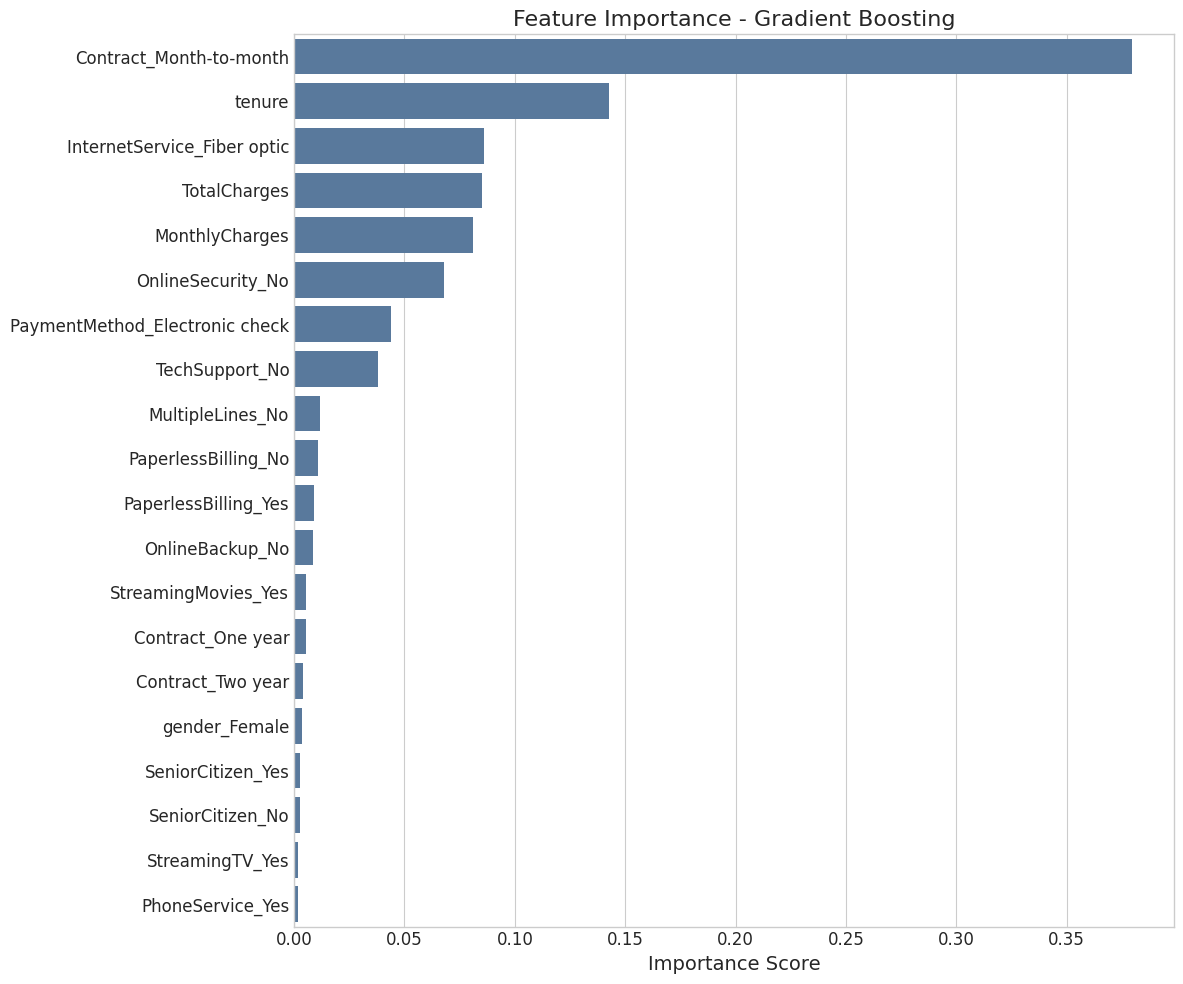

In [159]:
importance_fig = plot_feature_importance(
    best_model, all_feature_names, f"Feature Importance - {best_model_name}"
)

In [160]:
save_fig(
    importance_fig,
    f"feature_importance_{best_model_name.lower().replace(' ', '_')}.png",
)

Figure saved: ../reports/figures/feature_importance_gradient_boosting.png


## 7.0 Hyperparameter Tuning


In [161]:
param_grids = {
    "Logistic Regression": {
        "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__penalty": ["l1", "l2", "elasticnet", None],
        "classifier__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    },
    "Random Forest": {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__max_depth": [None, 10, 20, 30],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4],
    },
    "Gradient Boosting": {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__learning_rate": [0.01, 0.05, 0.1],
        "classifier__max_depth": [3, 5, 7],
        "classifier__min_samples_split": [2, 5],
        "classifier__subsample": [0.8, 1.0],
    },
    "XGBoost": {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__learning_rate": [0.01, 0.05, 0.1],
        "classifier__max_depth": [3, 5, 7],
        "classifier__subsample": [0.8, 0.9, 1.0],
        "classifier__colsample_bytree": [0.8, 0.9, 1.0],
        "classifier__gamma": [0, 0.1, 0.2],
    },
    "LightGBM": {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__learning_rate": [0.01, 0.05, 0.1],
        "classifier__max_depth": [3, 5, 7, -1],
        "classifier__num_leaves": [31, 50, 100],
        "classifier__subsample": [0.8, 0.9, 1.0],
        "classifier__colsample_bytree": [0.8, 0.9, 1.0],
    },
}

Check if there's a param grid for the best model


Tuning hyperparameters for Gradient Boosting...
Parameter grid: {'classifier__n_estimators': [100, 200, 300], 'classifier__learning_rate': [0.01, 0.05, 0.1], 'classifier__max_depth': [3, 5, 7], 'classifier__min_samples_split': [2, 5], 'classifier__subsample': [0.8, 1.0]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Hyperparameter tuning completed in 5.14 minutes
Best parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best cross-validation score: 0.8503

Model Evaluation: Tuned Gradient Boosting
Accuracy: 0.8091
Precision: 0.6842
Recall: 0.5214
F1 Score: 0.5918
ROC AUC: 0.8465
Average Precision: 0.6607
Specificity: 0.9130

Confusion Matrix:
TN: 945, FP: 90, FN: 179, TP: 195

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1035
           1       0.68      0.52      0.5

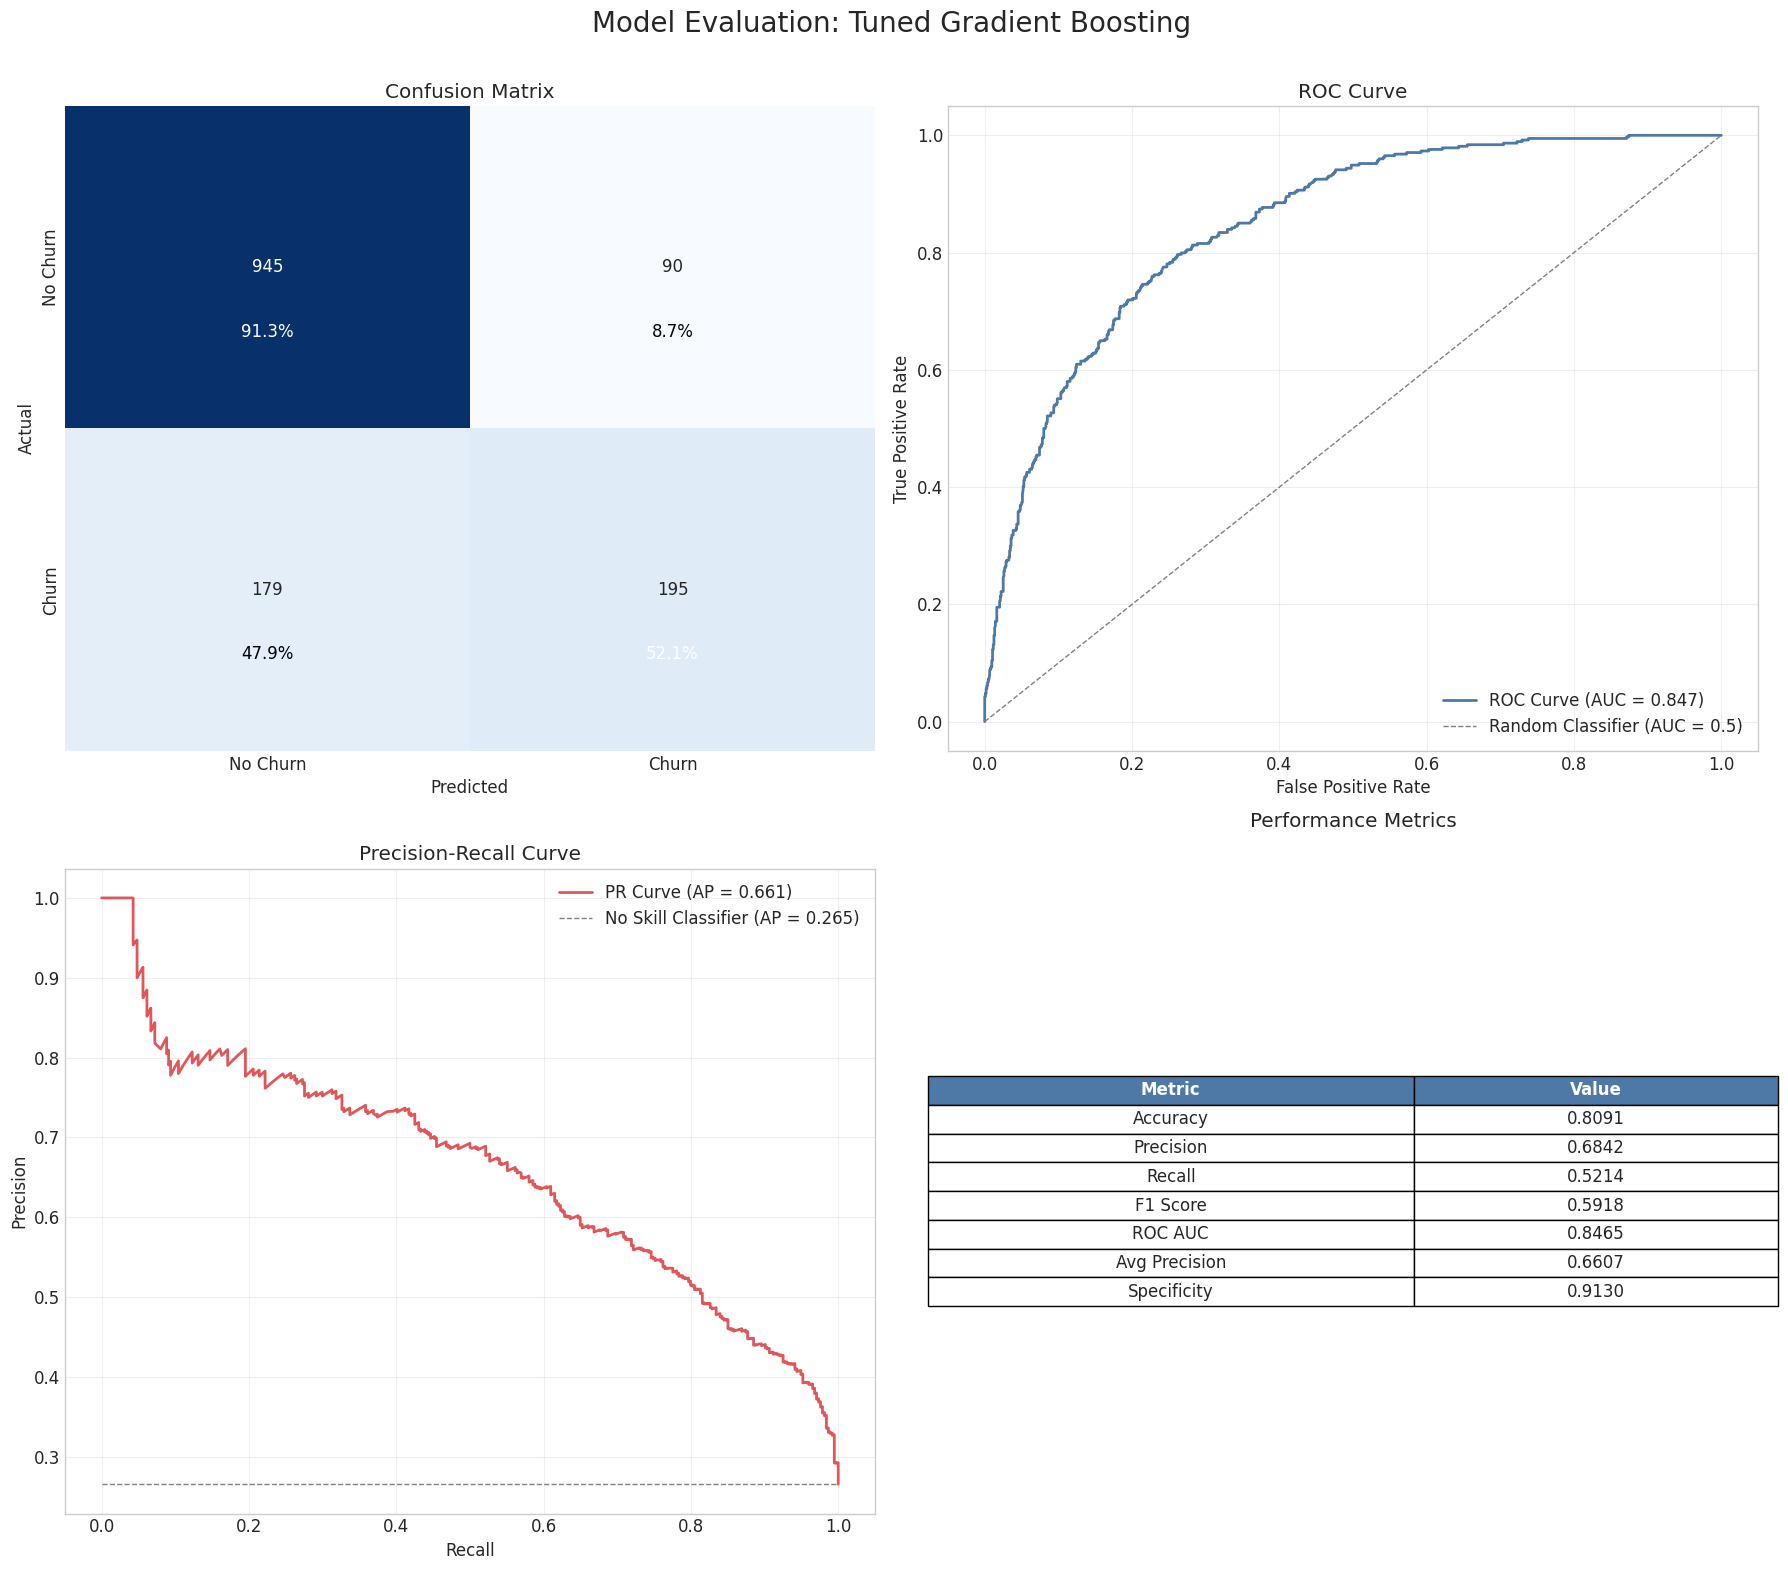


Evaluation completed in 1.81 seconds
Model saved: ../models/tuned_gradient_boosting.pkl
Figure saved: ../reports/figures/feature_importance_tuned_gradient_boosting.png


,model,accuracy,precision,recall,f1,roc_auc
0,Gradient Boosting,0.802697,0.665517,0.516043,0.581325,0.843384
1,Tuned Gradient Boosting,0.809084,0.684211,0.521390,0.591806,0.846528


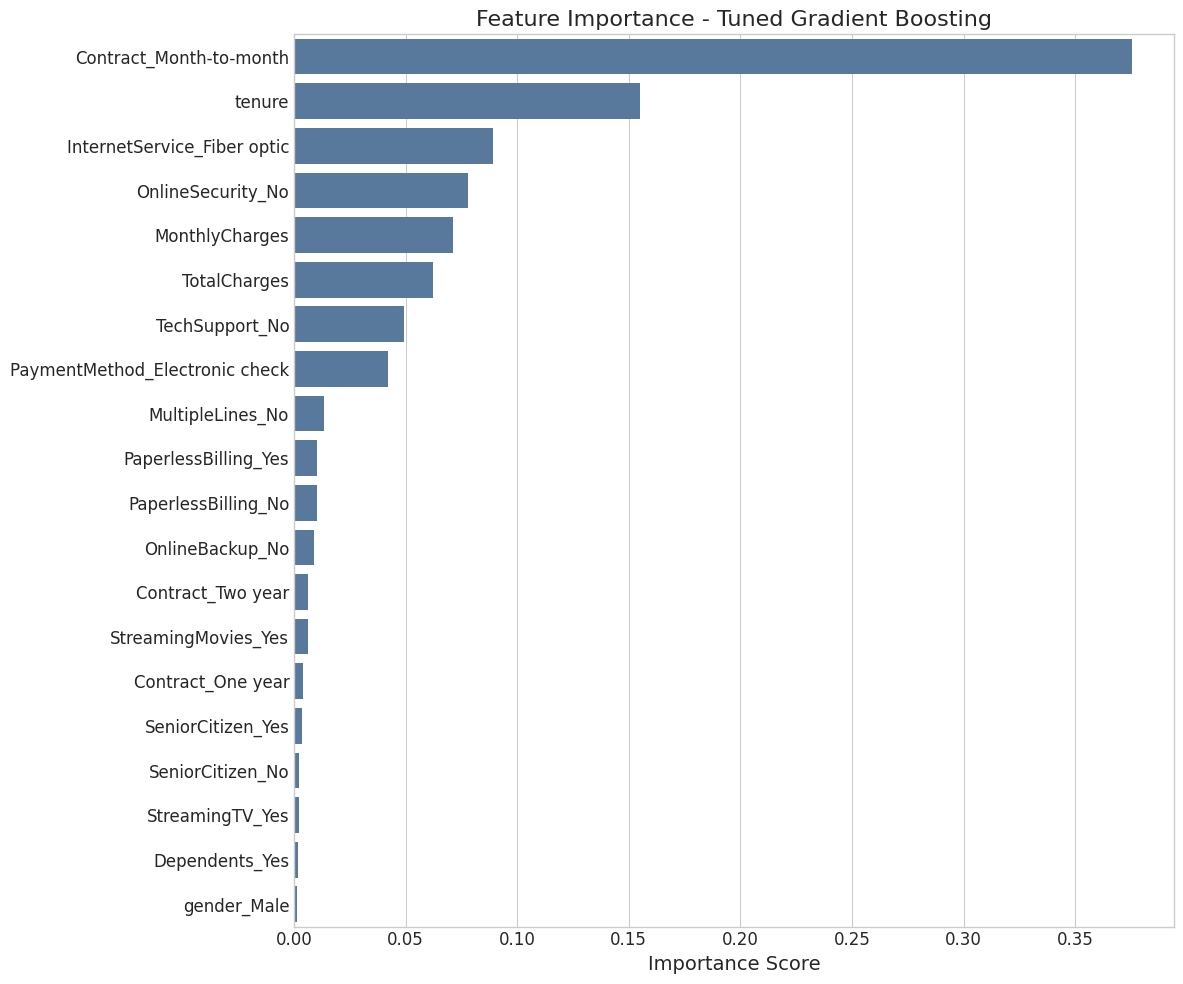

In [162]:
if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]

    print(f"Tuning hyperparameters for {best_model_name}...")
    print(f"Parameter grid: {param_grid}")

    cv = StratifiedKFold(
        n_splits=CONFIG["cv_folds"], shuffle=True, random_state=CONFIG["random_seed"]
    )

    scoring = {
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "roc_auc": "roc_auc",
    }

    grid_search = GridSearchCV(
        estimator=best_model,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=CONFIG["n_jobs"],
        verbose=1,
        return_train_score=True,
    )

    tuning_start_time = time.time()
    grid_search.fit(X_train, y_train)

    tuning_time = time.time() - tuning_start_time
    print(f"\nHyperparameter tuning completed in {format_runtime(tuning_time)}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Get best model
    tuned_model = grid_search.best_estimator_
    tuned_metrics = evaluate_model(
        tuned_model, X_test, y_test, f"Tuned {best_model_name}"
    )

    save_model(tuned_model, f"tuned_{best_model_name.lower().replace(' ', '_')}")

    tuned_importance_fig = plot_feature_importance(
        tuned_model, all_feature_names, f"Feature Importance - Tuned {best_model_name}"
    )

    save_fig(
        tuned_importance_fig,
        f"feature_importance_tuned_{best_model_name.lower().replace(' ', '_')}.png",
    )

    comparison_df = pd.DataFrame(
        [
            {
                "model": best_model_name,
                "accuracy": baseline_df.loc[
                    baseline_df["model_name"] == best_model_name, "accuracy"
                ].values[0],
                "precision": baseline_df.loc[
                    baseline_df["model_name"] == best_model_name, "precision"
                ].values[0],
                "recall": baseline_df.loc[
                    baseline_df["model_name"] == best_model_name, "recall"
                ].values[0],
                "f1": baseline_df.loc[
                    baseline_df["model_name"] == best_model_name, "f1"
                ].values[0],
                "roc_auc": baseline_df.loc[
                    baseline_df["model_name"] == best_model_name, "roc_auc"
                ].values[0],
            },
            {
                "model": f"Tuned {best_model_name}",
                "accuracy": tuned_metrics["accuracy"],
                "precision": tuned_metrics["precision"],
                "recall": tuned_metrics["recall"],
                "f1": tuned_metrics["f1"],
                "roc_auc": tuned_metrics["roc_auc"],
            },
        ]
    )

    display(comparison_df)
    comparison_df.to_csv(
        Path(CONFIG["results_path"]) / "baseline_vs_tuned_comparison.csv", index=False
    )

else:
    print(
        f"No parameter grid defined for {best_model_name}. Skipping hyperparameter tuning."
    )

## 8.0 Model Interpretation


In [163]:
def analyze_feature_impact(model, X_sample, feature_names, top_n=10):
    """
    Analyze the impact of features on predictions for a sample of data
    by perturbing each feature and measuring the change in prediction

    Args:
        model: Trained model
        X_sample: Sample data to analyze
        feature_names: Names of features
        top_n: Number of top features to show
    """

    impacts = []
    baseline_pred = model.predict_proba(X_sample)[:, 1].mean()

    for i, feature in enumerate(feature_names):
        X_perturbed = X_sample.copy()

        if X_sample[feature].dtype == "object":
            continue

        std_dev = X_sample[feature].std()
        X_perturbed[feature] = X_perturbed[feature] + std_dev

        new_pred = model.predict_proba(X_perturbed)[:, 1].mean()
        impact = new_pred - baseline_pred

        impacts.append(
            {
                "Feature": feature,
                "Impact": impact,
                "Direction": "Positive" if impact > 0 else "Negative",
            }
        )

    impact_df = pd.DataFrame(impacts)
    impact_df = impact_df.sort_values("Impact", key=abs, ascending=False).head(top_n)

    return impact_df

Select a subset of high-risk customers for analysis


In [164]:
high_risk = X_test[y_test == 1].sample(10, random_state=CONFIG["random_seed"])

Feature impact analysis for high-risk customers:
          Feature    Impact Direction
0          tenure -0.148470  Negative
1  MonthlyCharges  0.044386  Positive
2    TotalCharges -0.003070  Negative


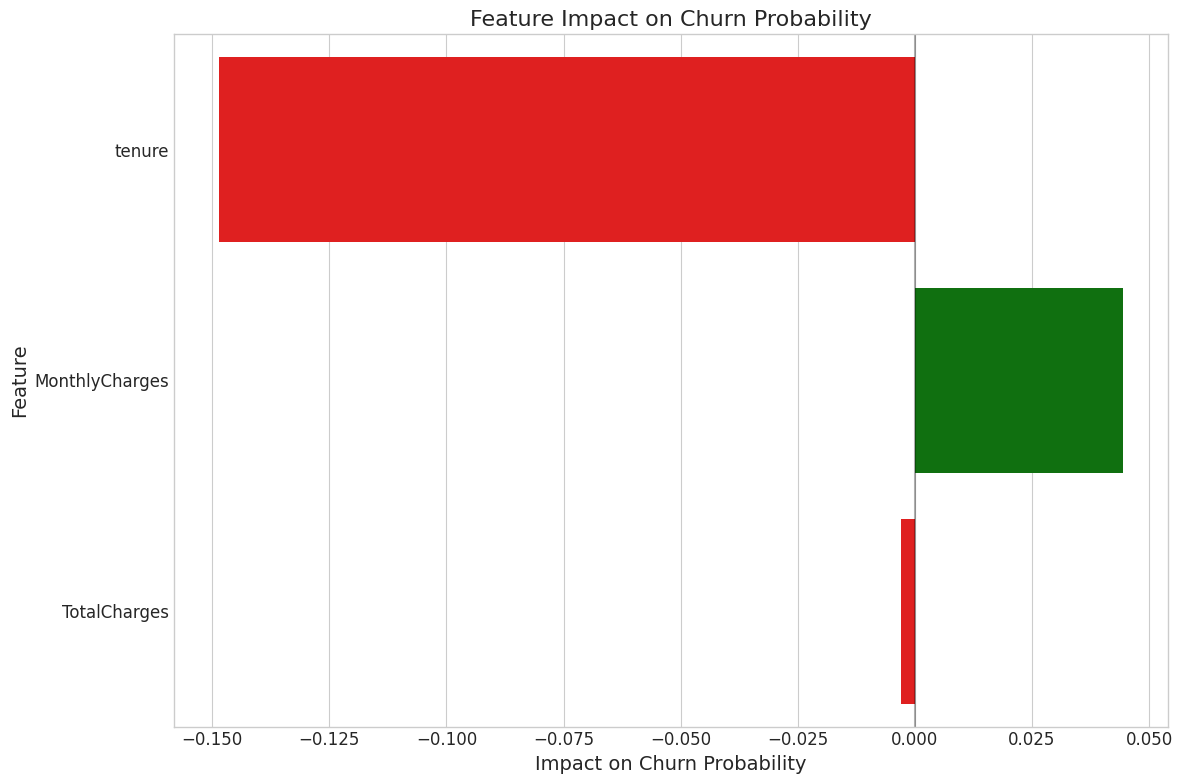

In [165]:
if hasattr(best_model, "predict_proba"):
    impact_df = analyze_feature_impact(best_model, high_risk, high_risk.columns)

    print("Feature impact analysis for high-risk customers:")
    print(impact_df)

    plt.figure(figsize=(12, 8))

    colors = ["red" if x < 0 else "green" for x in impact_df["Impact"]]
    sns.barplot(x="Impact", y="Feature", data=impact_df, palette=colors)

    plt.title("Feature Impact on Churn Probability", fontsize=16)
    plt.xlabel("Impact on Churn Probability", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
    plt.tight_layout()

    plt.savefig(Path(CONFIG["figures_path"]) / "feature_impact_analysis.png", dpi=300)
    plt.show()

## 9.0 Business Recommendations


In [166]:
if hasattr(best_model, "named_steps") and hasattr(
    best_model.named_steps["classifier"], "feature_importances_"
):
    feature_importance = pd.DataFrame(
        {
            "Feature": all_feature_names,
            "Importance": best_model.named_steps["classifier"].feature_importances_,
        }
    )

    top_features = feature_importance.sort_values("Importance", ascending=False).head(5)

    print("Top 5 drivers of customer churn:")
    for i, (_, row) in enumerate(top_features.iterrows()):
        print(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}")

    print("\nBusiness Recommendations:")
    for feature in top_features["Feature"]:
        if "Contract" in feature:
            print(
                "- Encourage month-to-month customers to switch to long-term contracts with incentives"
            )

        elif "tenure" in feature.lower():
            print(
                "- Implement special retention programs for customers in their first 12 months"
            )

        elif "monthly" in feature.lower() and "charge" in feature.lower():
            print("- Review pricing strategy for high-cost services")

        elif "online" in feature.lower() and "security" in feature.lower():
            print("- Promote online security services more actively to customers")

        elif "tech" in feature.lower() and "support" in feature.lower():
            print("- Improve and highlight the value of technical support services")

        elif "payment" in feature.lower():
            print("- Offer discounts for automatic payment methods")

        elif "service" in feature.lower() and "count" in feature.lower():
            print("- Design bundle offers to increase service adoption")

Top 5 drivers of customer churn:
1. Contract_Month-to-month: 0.3796
2. tenure: 0.1424
3. InternetService_Fiber optic: 0.0861
4. TotalCharges: 0.0849
5. MonthlyCharges: 0.0808

Business Recommendations:
- Encourage month-to-month customers to switch to long-term contracts with incentives
- Implement special retention programs for customers in their first 12 months
- Review pricing strategy for high-cost services


## 10.0 Deployment Preparation


In [167]:
def prepare_production_model(model, model_name):
    """
    Prepare a production-ready version of the model with example code

    Args:
        model: Trained model to deploy
        model_name: Name of the model
    """

    save_model(model, f"production_{model_name.lower().replace(' ', '_')}")

    def predict_churn_risk(customer_data):
        """
        Predict churn risk for new customer data

        Args:
            customer_data: DataFrame containing customer features

        Returns:
            DataFrame with customer IDs, churn probabilities, and risk level
        """

        required_cols = numerical_cols + categorical_cols
        missing_cols = [
            col for col in required_cols if col not in customer_data.columns
        ]

        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        if CONFIG["id_column"] in customer_data.columns:
            X = customer_data.drop(CONFIG["id_column"], axis=1)
            ids = customer_data[CONFIG["id_column"]]

        else:
            X = customer_data.copy()
            ids = pd.Series(range(len(X)))

        churn_prob = model.predict_proba(X)[:, 1]
        risk_level = pd.cut(
            churn_prob,
            bins=[0, 0.3, 0.6, 1.0],
            labels=["Low", "Medium", "High"],
            include_lowest=True,
        )

        results = pd.DataFrame(
            {"CustomerID": ids, "ChurnProbability": churn_prob, "RiskLevel": risk_level}
        )

        return results

    print(
        f"Production model saved as: production_{model_name.lower().replace(' ', '_')}.pkl"
    )

    return predict_churn_risk

In [168]:
best_production_model = tuned_model if "tuned_model" in locals() else best_model
prediction_function = prepare_production_model(best_production_model, best_model_name)

Model saved: ../models/production_gradient_boosting.pkl
Production model saved as: production_gradient_boosting.pkl


Test prediction function on some test data


In [169]:
test_sample = X_test.sample(5, random_state=CONFIG["random_seed"])

try:
    predictions = prediction_function(test_sample)
    display(predictions)

except Exception as e:
    print(f"Error testing prediction function: {str(e)}")

,CustomerID,ChurnProbability,RiskLevel
0,0,0.206931,Low
1,1,0.420775,Medium
2,2,0.025020,Low
3,3,0.605004,High
4,4,0.065039,Low


## 11.0 Conclusion


In [170]:
project_end_time = time.time()
total_runtime = project_end_time - project_start_time

In [171]:
print(f"Total runtime: {format_runtime(total_runtime)}")
print(f"Best model: {best_model_name}")
print(f"Best model ROC AUC: {baseline_df.iloc[0]['roc_auc']:.4f}")

if "tuned_model" in locals():
    print(f"Tuned model ROC AUC: {tuned_metrics['roc_auc']:.4f}")
    improvement = (
        (tuned_metrics["roc_auc"] - baseline_df.iloc[0]["roc_auc"])
        / baseline_df.iloc[0]["roc_auc"]
        * 100
    )
    print(f"Improvement from tuning: {improvement:.2f}%")

Total runtime: 5.46 minutes
Best model: Gradient Boosting
Best model ROC AUC: 0.8434
Tuned model ROC AUC: 0.8465
Improvement from tuning: 0.37%
